In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

2023-04-07 18:16:00.027580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 18:16:00.181934: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 18:16:00.184928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 18:16:00.184944: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
import csv
import pandas as pd


train=pd.read_csv('easy_train.csv')
test = pd.read_csv('easy_test.csv')
test.to_csv('bt_small1.txt', sep='\t', index=False)
train.to_csv('bt_small2.txt', sep='\t', index=False)

In [3]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
train = read_text("bt_small2.txt")
test = read_text("bt_small1.txt")
train = to_lines(train)
test = to_lines(test)
train = array(train)
test = array(test)

In [6]:
# convert text to lowercase
for i in range(1,len(train)):
    train[i,1] = train[i,1].lower()
    train[i,2] = train[i,2].lower()
for i in range(1,len(test)):
    test[i,1] = test[i,1].lower()
    test[i,2] = test[i,2].lower()

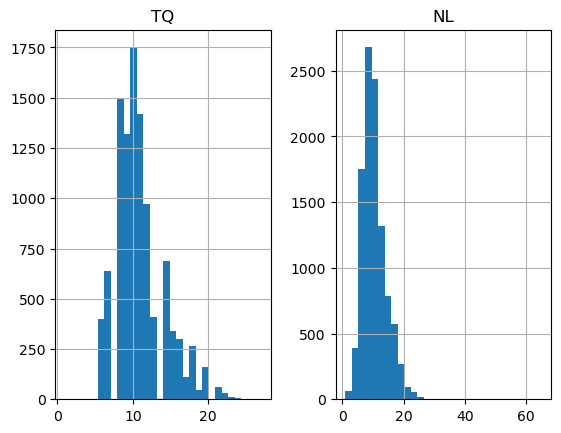

In [19]:
# empty lists
TQ_l = []
NL_l = []

# populate the lists with sentence lengths
for i in train[:,1]:
      TQ_l.append(len(i.split()))

for i in train[:,2]:
      NL_l.append(len(i.split()))

length_df = pd.DataFrame({'TQ':TQ_l, 'NL':NL_l})

length_df.hist(bins = 30)
plt.show()

In [9]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer(filters='!"#$%&*+,-:;<=>@[\\]^_`{|}~\t\n')
    #tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [20]:
# prepare english tokenizer
TQ_tokenizer1 = tokenization(train[:, 1])
TQ_tokenizer2 = tokenization(test[:, 1])
TQ_vocab_size = len(TQ_tokenizer1.word_index) + 1

TQ_length = 18
print('English Vocabulary Size: %d' % TQ_vocab_size)
TQ_tokenizer1

English Vocabulary Size: 6887


In [21]:
# prepare Deutch tokenizer
NL_tokenizer1 = tokenization(train[:, 2])
NL_tokenizer2 = tokenization(test[:, 2])
NL_vocab_size = len(NL_tokenizer1.word_index) + 1

NL_length = 18
print('Deutch Vocabulary Size: %d' % NL_vocab_size)

Deutch Vocabulary Size: 6696


In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [23]:
# prepare training data
trainX = encode_sequences(NL_tokenizer1, NL_length, train[:, 2])
trainY = encode_sequences(TQ_tokenizer1,TQ_length, train[:, 1])

# prepare validation data
testX = encode_sequences(NL_tokenizer2, NL_length, test[:, 2])
testY = encode_sequences(TQ_tokenizer2, TQ_length, test[:, 1])

In [24]:
# build model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [25]:
# model compilation
model = define_model(NL_vocab_size, TQ_vocab_size, NL_length, TQ_length, 1024)

2023-04-07 18:24:01.164749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 18:24:01.164832: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-07 18:24:01.164871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-07 18:24:01.164908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-04-07 18:24:01.184974: W tensorfl

In [26]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/home/wenlong/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [27]:
filename = 'model.h1.latest'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
print(trainY.shape)

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

(10433, 18)
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 4.5278
Epoch 1: val_loss improved from inf to 3.56158, saving model to model.h1.latest


INFO:tensorflow:Assets written to: model.h1.latest/assets


INFO:tensorflow:Assets written to: model.h1.latest/assets


17/17 [==============================] - 45s 2s/step - loss: 4.5278 - val_loss: 3.5616
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 3.3618
Epoch 2: val_loss improved from 3.56158 to 3.14109, saving model to model.h1.latest


INFO:tensorflow:Assets written to: model.h1.latest/assets


INFO:tensorflow:Assets written to: model.h1.latest/assets


17/17 [==============================] - 41s 2s/step - loss: 3.3618 - val_loss: 3.1411
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 3.0944
Epoch 3: val_loss did not improve from 3.14109
17/17 [==============================] - 31s 2s/step - loss: 3.0944 - val_loss: 3.6253
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 3.0052
Epoch 4: val_loss improved from 3.14109 to 2.97195, saving model to model.h1.latest


INFO:tensorflow:Assets written to: model.h1.latest/assets


INFO:tensorflow:Assets written to: model.h1.latest/assets


17/17 [==============================] - 41s 2s/step - loss: 3.0052 - val_loss: 2.9720
Epoch 5/10
17/17 [==============================] - ETA: 0s - loss: 2.9803
Epoch 5: val_loss improved from 2.97195 to 2.85740, saving model to model.h1.latest


INFO:tensorflow:Assets written to: model.h1.latest/assets


INFO:tensorflow:Assets written to: model.h1.latest/assets


17/17 [==============================] - 42s 2s/step - loss: 2.9803 - val_loss: 2.8574
Epoch 6/10
17/17 [==============================] - ETA: 0s - loss: 2.7516
Epoch 6: val_loss improved from 2.85740 to 2.77587, saving model to model.h1.latest


INFO:tensorflow:Assets written to: model.h1.latest/assets


INFO:tensorflow:Assets written to: model.h1.latest/assets


17/17 [==============================] - 40s 2s/step - loss: 2.7516 - val_loss: 2.7759
Epoch 7/10
17/17 [==============================] - ETA: 0s - loss: 2.6017
Epoch 7: val_loss improved from 2.77587 to 2.63205, saving model to model.h1.latest


INFO:tensorflow:Assets written to: model.h1.latest/assets


INFO:tensorflow:Assets written to: model.h1.latest/assets


17/17 [==============================] - 40s 2s/step - loss: 2.6017 - val_loss: 2.6321
Epoch 8/10
17/17 [==============================] - ETA: 0s - loss: 2.4603
Epoch 8: val_loss improved from 2.63205 to 2.57112, saving model to model.h1.latest


INFO:tensorflow:Assets written to: model.h1.latest/assets


INFO:tensorflow:Assets written to: model.h1.latest/assets


17/17 [==============================] - 40s 2s/step - loss: 2.4603 - val_loss: 2.5711
Epoch 9/10
17/17 [==============================] - ETA: 0s - loss: 2.3152
Epoch 9: val_loss improved from 2.57112 to 2.37553, saving model to model.h1.latest


INFO:tensorflow:Assets written to: model.h1.latest/assets


INFO:tensorflow:Assets written to: model.h1.latest/assets


17/17 [==============================] - 41s 2s/step - loss: 2.3152 - val_loss: 2.3755
Epoch 10/10
17/17 [==============================] - ETA: 0s - loss: 2.1605
Epoch 10: val_loss improved from 2.37553 to 2.35655, saving model to model.h1.latest


INFO:tensorflow:Assets written to: model.h1.latest/assets


INFO:tensorflow:Assets written to: model.h1.latest/assets


17/17 [==============================] - 40s 2s/step - loss: 2.1605 - val_loss: 2.3565


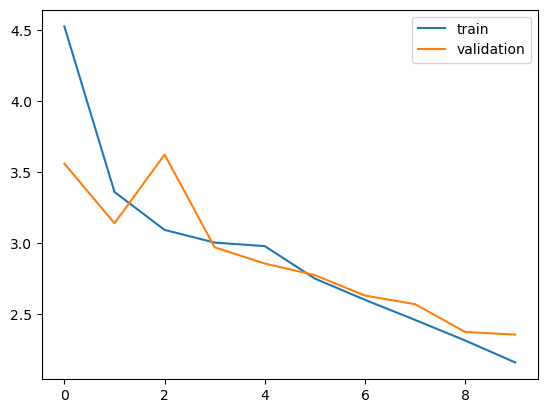

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [30]:
import numpy as np
model = load_model('model.h1.latest')
preds = np.argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))),axis = -1)

2023-04-09 15:05:15.169316: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-09 15:05:15.179621: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-09 15:05:15.407805: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-09 15:05:15.438762: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-09 15:05:16.292955: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

41/41 [==============================] - 4s 78ms/step


In [31]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [36]:
# convert predictions into text (English)
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], TQ_tokenizer1)
    if j>0:
      if(t == get_word(i[j-1], TQ_tokenizer1)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else:
        temp.append(t)

  preds_text.append(' '.join(temp))

In [42]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})
# print 15 rows randomly
print(pred_df)

                                                                                              actual  \
0                                                                                                 tp   
1                                               how many patients are dignosed of anxiety disorder?    
2                                                     return all 1.33 years old vaccine recipients.    
3      what is the number of the cases where the vaccine recipient had hib (no brand name) vaccine.    
4                            list all the recipients who took rubella and dtap+ipv+hib+hepb before.    
...                                                                                              ...   
1300                                  give me all the patients who got rotavirus (rotarix) vaccine.    
1301                   give me all the patients who have genetic counselling after the vaccination.    
1302                                        provide all records 

In [64]:
from torchmetrics.functional.text.rouge import rouge_score
score=rouge_score(test[:,1],preds_text,accumulate='avg')
score

{'rouge1_fmeasure': tensor(0.7803),
 'rouge1_precision': tensor(0.7210),
 'rouge1_recall': tensor(0.8605),
 'rouge2_fmeasure': tensor(0.6712),
 'rouge2_precision': tensor(0.6167),
 'rouge2_recall': tensor(0.7466),
 'rougeL_fmeasure': tensor(0.7760),
 'rougeL_precision': tensor(0.7172),
 'rougeL_recall': tensor(0.8553),
 'rougeLsum_fmeasure': tensor(0.7760),
 'rougeLsum_precision': tensor(0.7173),
 'rougeLsum_recall': tensor(0.8555)}

In [99]:
import re
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1'])
means_score=[]
precision=[]
for i in range(len(preds_text)):
    a=scorer.score(test[i,1],preds_text[i])
    b = re.findall('(?<=precision=)((-?\d+)(\.\d+)?)',str(a))
    precision.append(b)
    means_score.append(scorer.score(test[i,1],preds_text[i]))
#   means_score_f=means_score_f+means_score
#means_score_f=means_score_f/len(ground_truth)
precision

[[('0.0', '0', '.0')],
 [('0.0', '0', '.0')],
 [('0.0', '0', '.0')],
 [('0.18181818181818182', '0', '.18181818181818182')],
 [('0.5', '0', '.5')],
 [('0.16666666666666666', '0', '.16666666666666666')],
 [('0.2', '0', '.2')],
 [('0.3333333333333333', '0', '.3333333333333333')],
 [('0.18181818181818182', '0', '.18181818181818182')],
 [('0.2', '0', '.2')],
 [('0.6', '0', '.6')],
 [('0.0', '0', '.0')],
 [('0.15384615384615385', '0', '.15384615384615385')],
 [('0.125', '0', '.125')],
 [('0.7777777777777778', '0', '.7777777777777778')],
 [('0.21428571428571427', '0', '.21428571428571427')],
 [('0.1111111111111111', '0', '.1111111111111111')],
 [('0.18181818181818182', '0', '.18181818181818182')],
 [('0.3', '0', '.3')],
 [('0.15384615384615385', '0', '.15384615384615385')],
 [('0.0', '0', '.0')],
 [('0.6', '0', '.6')],
 [('0.16666666666666666', '0', '.16666666666666666')],
 [('0.2', '0', '.2')],
 [('0.0', '0', '.0')],
 [('0.16666666666666666', '0', '.16666666666666666')],
 [('0.35294117647058

In [100]:
import pandas as pd

df1 = pd.DataFrame(columns = ['ID','results','ground_truth','rouge1'])

for i in range(len(preds_text)):
    
    df1.loc[i] = {'results':preds_text[i],'ground_truth':test[i,1],'rouge1':precision[i][0][0]}

df1

,ID,results,ground_truth,rouge1
0,NaN,give me all the patients whose interval from the vaccination date to the onset date is days.,tp,0.0
1,NaN,find all the records where the adverse event started on,how many patients are dignosed of anxiety disorder?,0.0
2,NaN,how many patients are allergic to narcotics?,return all 1.33 years old vaccine recipients.,0.0
3,NaN,how many patients whose of has of date to event is,what is the number of the cases where the vaccine recipient had hib (no brand name) vaccine.,0.18181818181818182
4,NaN,give me all the patients who got meningococcal and before.,list all the recipients who took rubella and dtap+ipv+hib+hepb before.,0.5
...,...,...,...,...
1039,NaN,give me all the patients who had test of,what is the number of records that the vaccine recipient got uspfizer inc2021405790 vaccine.,0.2222222222222222
1040,NaN,give me all the patients whose date of vaccination is,how many people got vaccine in lg and ll.,0.0
1041,NaN,find the day most when the most people choose to,how many patients are dignosed of lung cancer?,0.0
1042,NaN,return all records whose cage year is,give me all the patients who got vaccine frommass. pub hlth biol lab.,0.14285714285714285


In [101]:
fial_ground=[]
for i in range(len(preds_text)):
    if float(df1.iat[i,3])>0.9:
        fial_ground.append(df1.iloc[i])
fial_ground            

[ID                                                                                       NaN
 results             find all the cases where the vaccine recipients got vaccinated in       
 ground_truth     find all the cases where the vaccine recipients got vaccinated in ew01863. 
 rouge1                                                                                   1.0
 Name: 167, dtype: object,
 ID                                                                                 NaN
 results         return all the cases where the vaccine recipients was reported        
 ground_truth     return all the cases where the vaccine recipients was reported foot. 
 rouge1                                                                             1.0
 Name: 296, dtype: object,
 ID                                                                                        NaN
 results                return all the cases where the vaccine recipients was reported        
 ground_truth     return all

In [ ]:
import pandas as pd
from pandas.core.frame import DataFrame
df_f=DataFrame(fial_ground)
df_f.to_excel('lstm_test.xlsx')